---
# Advanced Lane Finding

Udacity - Self-Driving Car NanoDegree

In this project, an advanced lane detection algorithm was impelemented. Below an overview of the pipeline and relevant results are presented.

## Pipeline

1. Camera calibration and distortion matrix calculation
2. For a given image do
3. Unistort image
4. Transform image street perpective
5. Apply sobel, color and s-channel filtering
6. Slice the image and create histograms of lane points per slice
7. Smooth the histograms and extract local maximum points
8. If two maximum's are found, one on the left and one on the right, fit a polygonal on each side
9. Calculate curvature per polynomial
10. Filter polynomials if curvatures do not match
11. Invert project lanes to original image space


### Basic imports

In [15]:
import imageio
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import glob
from scipy import signal
from scipy.signal import find_peaks_cwt
from scipy.signal import argrelextrema
from moviepy.editor import VideoFileClip
import scipy.misc
import matplotlib.gridspec as gridspec


## 1. Apply distortion-correction to raw image.

### Load calibration images

I load all calibration images to the array: image_list

In [2]:


%matplotlib inline

nx = 9
ny = 6

image_list = []
for filename in glob.glob('camera_cal/*.jpg'):
    image_list.append(cv2.imread(filename))
    
print('Done!')


Done!


### Calibrate to generate coefficients

First I convert the images to grayscale and then apply the findChessboardCorners to get all corners. The calibrateCamera method of opencv eventually generates the camera matrix and coefficients.

In [3]:

objpoints = []
imgpoints = []
    
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
for image in image_list:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera( objpoints, 
                                                        imgpoints, 
                                                        gray.shape[::-1], 
                                                        None, 
                                                        None)

print('Done!')


Done!


### The undistort method

The cv2.undistort method can undistort an image give the camera matrix and coefficients

In [4]:
def undistort(img):
    img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, camera_matrix)
    return img_undistorted


### Load and display a test image

The undistort seems to work fine since the image on the right has been corrected to contain straight lines

Done!


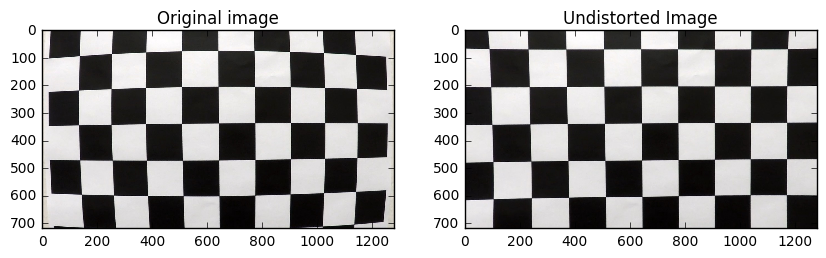

In [27]:
image = cv2.cvtColor(image_list[7], cv2.COLOR_BGR2RGB)
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 30]) 

f = plt.figure(figsize=(10, 8))
f1 = plt.subplot(gs[0])
f1.imshow(image)
f1.set_title('Original image')

f2 = plt.subplot(gs[1])
f2.imshow(undistort(image))
f2.set_title('Undistorted Image')

print('Done!')

An example of undistortion on an image collected while driving

Done!


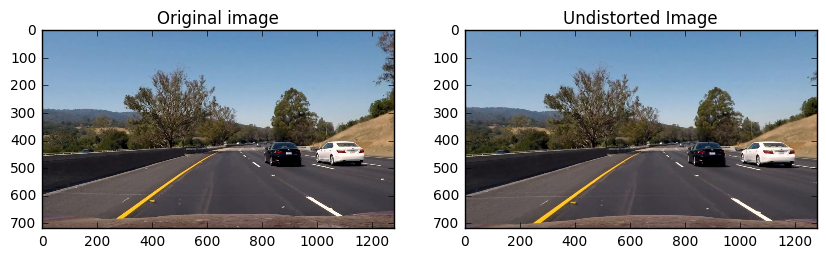

In [30]:

image = cv2.imread('./hard2/outfile993.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 30]) 

f = plt.figure(figsize=(10, 8))
f1 = plt.subplot(gs[0])
f1.imshow(image)
f1.set_title('Original image')

f2 = plt.subplot(gs[1])
f2.imshow(undistort(image))
f2.set_title('Undistorted Image')

print('Done!')

## 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color, sobel x and s-channel filtering (from HLS) to generate a binary image (as shown below)

The formula used is: (sobel_x AND rgb_filtering) OR hls_s_channel

This indicates that a pixel is marked as possible lane 
 - if the x gradient is TRUE and the RBG color is white or yellow 
 - or if the s channel of HLS is inside the threshold

### Define methods for sobel_x filtering, HLS thresholding on s-channel and RGB filtering

In [175]:

def apply_sobel_x(image, thresh_min=20, thresh_max=200):
    # Sobel x
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Apply a threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def apply_hls_threshold(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #plt.imshow(s_channel)
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= 130) & (s_channel <= 240)) | ((l_channel >= 220) & (l_channel <= 255))] = 1
    #print(s_binary)

    return s_binary

def get_color_selection(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    lower_yellow = np.array([0, 90, 90], dtype=np.uint8)
    upper_yellow = np.array([210,250,255], dtype=np.uint8)
    
    lower_white =np.array([170,170,170], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    
    # Get the white pixels from the original image
    mask_white = cv2.inRange(image, lower_white, upper_white)

    # Get the yellow pixels from the HSV image
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # Bitwise-OR white and yellow mask
    mask = cv2.bitwise_or(mask_white, mask_yellow)
    return mask

def threshold_image(image):

    binary_sobel = apply_sobel_x(image)
    binary_hls = apply_hls_threshold(image)
    binary_rbg = get_color_selection(image)
    
    # Combine all thresholds and filters
    combined_binary = np.zeros_like(binary_sobel)
    #combined_binary[:,:,0] = binary_sobel 
    #combined_binary[:,:,1] = binary_hls 
    #combined_binary[:,:,2] = binary_rbg 
    combined_binary[((binary_sobel == 1) | (binary_hls == 1)) | (binary_rbg == 1) ] = 1
    
    return combined_binary

def merge_images(img1, img2):
    return cv2.addWeighted(img1, 0.4, img2, 0.6, 0)


The three filters and their combination:

Done!


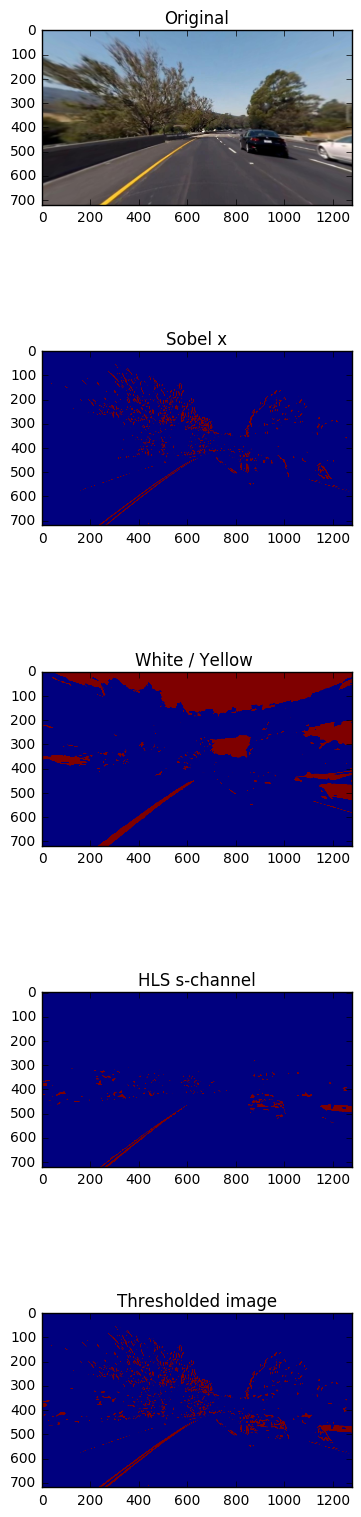

In [176]:

gs = gridspec.GridSpec(5, 1, width_ratios=[30, 30, 30, 30, 30]) 
filtered = threshold_image(image)
                           
f = plt.figure(figsize=(20, 20))
f0 = plt.subplot(gs[0])
f0.imshow(image)
f0.set_title('Original')

f1 = plt.subplot(gs[1])
f1.imshow(apply_sobel_x(image))
f1.set_title('Sobel x')

f2 = plt.subplot(gs[2])
f2.imshow(get_color_selection(image))
f2.set_title('White / Yellow ')

f3 = plt.subplot(gs[3])
f3.imshow(apply_hls_threshold(image))
f3.set_title('HLS s-channel')

f4 = plt.subplot(gs[4])
f4.imshow(filtered)
f4.set_title('Thresholded image')

print('Done!')


We can see that the filtering preserves most of the lane pixels (as desired)

## 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

### Define transformation points 

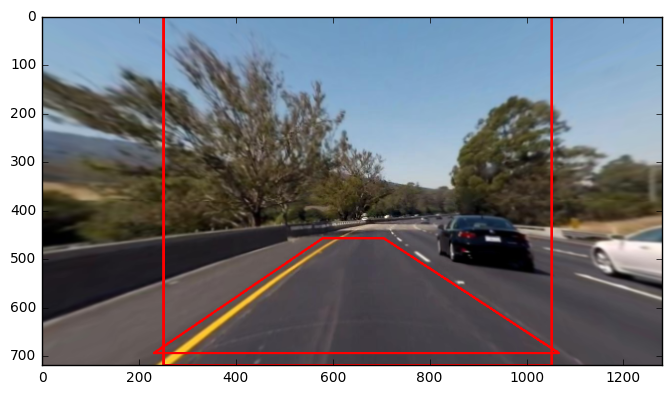

In [95]:
#find src points for projection
image = undistort(image)
h = image.shape[0]

src = np.int32([[230,695],[578,458],[704,458],[1065,695]])
dest = np.int32([[250,h],[250,0],[1050,0],[1050,h]])
#pts = pts.reshape((-1,1,2))
lanes_marked = np.copy(image)
lanes_marked = cv2.polylines(lanes_marked,[src],True,(255,0,0), thickness=3)
lanes_marked = cv2.polylines(lanes_marked,[dest],True,(255,0,0), thickness=3)

plt.figure(figsize=(8,8))
plt.imshow(lanes_marked)

### Define project and invert_project methods

In [96]:
def project(image):
    
    h = image.shape[0]
    w = image.shape[1]
    src = np.float32([[230,695],[578,458],[704,458],[1065,695]])
    dst = np.float32([[250,h],[250,0],[1050,0],[1050,h]]) 

    M = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(image, M, (w,h))
    return warped

def invert_project(image):
    
    h = image.shape[0]
    w = image.shape[1]
    src = np.float32([[230,695],[578,458],[704,458],[1065,695]])
    dst = np.float32([[250,h],[250,0],[1050,0],[1050,h]]) 

    M = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, (w,h))
    empty = np.zeros(warped.shape, dtype=np.uint8)
    final = np.dstack((warped, empty, empty))
    return final

### Example images for perspective transformation

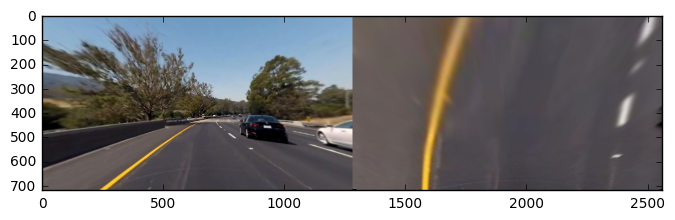

In [97]:

plt.figure(figsize=(8,8))
plot_image = np.concatenate((image, project(image)),axis=1) 
plt.imshow(plot_image)

### Define method to extract lane points from an image

In [98]:
def find_lane_points(image):
    height = image.shape[0]
    width = image.shape[1]
    window_size = 40
    left_lanes_x = []
    left_lanes_y = []
    right_lanes_x = []
    right_lanes_y = []
    for window_index in range(1,int(height / window_size)):
        window_lanes = image[window_index*window_size:(window_index+1)*window_size, :]
                           
        histogram = np.sum(window_lanes, axis=0)

        window = signal.general_gaussian(49, p=3, sig=40)
        filtered = signal.fftconvolve(window, histogram)
        filtered = (np.average(histogram) / np.average(filtered)) * filtered
        histogram = np.roll(filtered, -25)

        #plt.plot(histogram)
        indices = argrelextrema(histogram, np.greater)

        data_y_left = []
        data_x_left = []
        data_y_right = []
        data_x_right = []
    
        for i in indices[0]:
            if histogram[i] > 13:
                if i > 600:
                    data_x_right.append(i)
                    data_y_right.append(window_size*window_index)
                else:
                    data_x_left.append(i)
                    data_y_left.append(window_size*window_index)
            
        if len(data_x_left) == 1:
            left_lanes_x.append(data_x_left[0])
            left_lanes_y.append(data_y_left[0])

        if len(data_x_right) == 1:
            right_lanes_x.append(data_x_right[0])
            right_lanes_y.append(data_y_right[0])

    return left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y



### Example of detected lane points

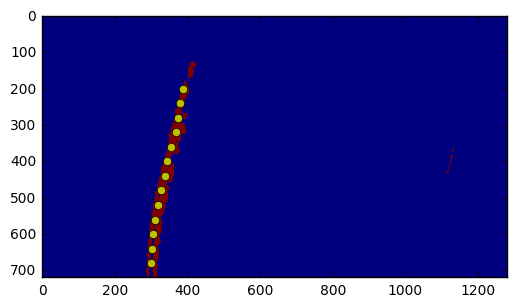

In [99]:
left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y = find_lane_points(project(lanes_image))
plt.plot(right_lanes_x, right_lanes_y, 'og')
plt.plot(left_lanes_x, left_lanes_y, 'oy')

plt.imshow(project(lanes_image))

### Curvature and car distance to lanes

In [62]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calculate_curvature(fit) :
    return ((ym_per_pix**2 + xm_per_pix**2*(2*fit[0]*720 + fit[1])**2)**1.5)/(2*xm_per_pix*ym_per_pix*fit[0])
    
def calc_base_dist(self, fit) :
    y = img_dim[1]
    dist = -img_dim[0]/2
    for i in range(self.poly_order+1) :
        dist += fit[i]*y**(self.poly_order-i)
    return dist*xm_per_pix


### Find lines method to fit polylines, export their detected points and return a layered image with left and right curvature

In [ ]:
def find_lines(image, left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y):
    #print(left_lanes_x)
    if len(left_lanes_x) < 3:
        return False, 0, 0, 0
    #print(right_lanes_x)
    if len(right_lanes_x) < 3:
        return False, 0, 0, 0
    
    overlay_lanes = np.copy(image)

    line = np.polyfit(left_lanes_y, left_lanes_x, deg=2)
    p = np.poly1d(line)
    x = list(range(0, image.shape[0]))
    y = list(map(int, p(x)))
    line1_pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    line1_pts = line1_pts.reshape((-1,1,2))
    cv2.polylines(overlay_lanes, np.int32([line1_pts]), False, color=(255,0,0), thickness=50)
    left_r = calculate_curvature(line)

    line = np.polyfit(right_lanes_y, right_lanes_x, deg=2)
    p = np.poly1d(line)
    x = list(range(0, image.shape[0]))
    y = list(map(int, p(x)))
    line2_pts = np.array([[_y,_x] for _x, _y in zip(x, y)])
    line2_pts = line2_pts.reshape((-1,1,2))
    cv2.polylines(overlay_lanes, np.int32([line2_pts]), False, color=(255,0,0), thickness=50)
    right_r = calculate_curvature(line)

    top_points = [line1_pts[-1], line2_pts[-1]]
    base_points = [line1_pts[0], line2_pts[0]]
    
    # Fill in the detected lane
    cv2.fillPoly(overlay_lanes, [np.concatenate((line2_pts, line1_pts, top_points, base_points))], color=(100,200,150))
    #cv2.putText(overlay_lanes, 'Vehicle is '+position+'m left of center', (50, 100), font, 1, (255, 255, 255), 2)
#    cv2.putText(overlay_lanes, 'Radius left: '+str(left_r)+' Radius right: '+str(right_r), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 100), 2)
#    cv2.putText(final_merged, str(i), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
#    print(left_r)
    plt.imshow(overlay_lanes)
    return True, overlay_lanes, left_r, right_r

success, overlay_lanes, left_r, right_r = find_lines(lanes_image, left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y)

if success == False:
    print('success = '+str(success))
    print('Failed to extract lanes')
else:
    f, (f1, f2) = plt.subplots(1, 2)
    f1.imshow(project(image))
    f1.set_title('Projected image')
    f2.imshow(overlay_lanes)
    f2.set_title('Lane area')


### Example of an output image

In [ ]:
final = invert_project(overlay_lanes)
#print(overlay_lanes.shape)
#print(image.shape)
final_merged = merge_images(final, image)
#print(final)
plt.imshow(final_merged)

### We use a history of the last history_size frames to make more stable detections of the lanes

In [ ]:
history_size = 5

In [ ]:
def history(history, current):
    size = len(history)
    if size < history_size:
        return current
    if history_size == 1:
        return current
    output = current
    for i in range(1, history_size + 1):
        output = output + history[size - i]
    return output

### The main pipeline as explained on top

In [ ]:
history_left_x, history_left_y, history_right_x, history_right_y = [],[],[],[]
old_lanes_image = []
i = 0
def process(image, useHistory = True):
    global old_lanes_image
    
    if i > 970 and i < 1010:
#    if i == 563 or i == 614 or i == 610 or i == 617 or i == 1025 or i == 1032 or i == 1047:
        scipy.misc.toimage(image, cmin=0.0, cmax=255).save('hard2/outfile'+str(i)+'.jpg')
    
    undistorted = undistort(image)
    projected = project(undistorted)
    
    lanes_image = threshold_image(projected)
    
    left_lanes_x, left_lanes_y, right_lanes_x, right_lanes_y = find_lane_points(lanes_image)
    
    history_left_x.append(left_lanes_x)
    history_left_y.append(left_lanes_y)
    history_right_x.append(right_lanes_x)
    history_right_y.append(right_lanes_y)
    
    history_length = len(history_left_x)
    if useHistory and history_length < history_size:
        #cv2.putText(image,"Collecting initial data", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        return image

    left_x = history(history_left_x, left_lanes_x)
    left_y = history(history_left_y, left_lanes_y)
    right_x = history(history_right_x, right_lanes_x)
    right_y = history(history_right_y, right_lanes_y)
    success, overlay_lanes, left_r, right_r = find_lines(lanes_image, left_x, left_y, right_x, right_y)

    if len(old_lanes_image) == 0:
        old_lanes_image = overlay_lanes
        
    if success == False:
        overlay_lanes = old_lanes_image
    if abs(left_r) < 280 or abs(right_r) < 280:
        overlay_lanes = old_lanes_image
    if left_r * right_r < 0:
        if abs(abs(left_r) - abs(right_r)) >2000 and (abs(left_r) < 1000 or abs(right_r) < 1000):
            overlay_lanes = old_lanes_image
        
    final = invert_project(overlay_lanes)
    final_merged = merge_images(final, image)
    
    old_lanes_image = overlay_lanes
    
    global i
    cv2.putText(final_merged, str(i), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(final_merged, 'Radius left: '+str(abs(left_r))+' Radius right: '+str(abs(right_r)), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 100), 2)
    

    i = i + 1
    return final_merged
print('Done!')

### Load input video and generate output video 

In [ ]:

white_output = './project_video_labeled.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

### Further results for some edge cases

In [ ]:
global i
i = 0
for filename in glob.glob('hard/*.jpg'):
    plt.figure(figsize=(6,6))

    print(filename)
    out = cv2.cvtColor(process(cv2.imread(filename), False), cv2.COLOR_BGR2RGB)
    plt.imshow(out)
    i = i + 1
print('Done!')
